In this notebook we are exploring 2 driving questions
- Did I achieve my goal of X steps more in the last 12 months than the 12 months before that?
- Do I have more steps on average during the weekend in comparison to a weekday?
In order to answer these questions we will be using datasets from 2 different people.

#  Import required libraries

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
from mayavi import mlab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import cm
mlab.init_notebook()

Notebook initialized with ipy backend.


# First read in data and clean data

Read in datasets using pandas


In [2]:
df1_raw = pd.read_csv('data/person1-step-data.csv')
df2_raw = pd.read_csv('data/person2-step-data.csv')

Check columns and their types, we can see that `Date` is still in str

In [3]:
print('Person 1 dtypes')
print(df1_raw.dtypes)
print('\nPerson 2 dtypes')
print(df2_raw.dtypes)

Person 1 dtypes
Source    object
Date      object
Hour       int64
Count      int64
dtype: object

Person 2 dtypes
Source    object
Date      object
Hour       int64
Count      int64
dtype: object


Convert columns to correct data type


In [4]:
df1 = df1_raw
df2 = df2_raw
df1['Date'] = pd.to_datetime(df1['Date'])
df2['Date'] = pd.to_datetime(df2['Date'])

Now we can explore the data, here we check number of 
- rows and columns
- unique number of sources step counts were gathered from
- start and end of data collection
- number of days where data is present
- quick check for the `hour` column

In [5]:
def summary(df):
    print(f"df shape: {df.shape}")
    print(f"Sources include {df['Source'].unique()}")
    print(f"First day: {df['Date'].min()}")
    print(f"Last day: {df['Date'].max()}")
    print(f"Number of days: {len(df['Date'].unique())}")
    print(f"First hour: {df['Hour'].min()}")
    print(f"Last hour: {df['Hour'].max()}")

In [6]:
summary(df1)

df shape: (183787, 4)
Sources include ['Person1 iPhone SE' 'Person1 Mi Fit' 'Person1 Misfit'
 'Person1 Health Mate' 'Person1 Apple\xa0Watch']
First day: 2014-12-07 00:00:00
Last day: 2021-09-22 00:00:00
Number of days: 2295
First hour: 0
Last hour: 23


In [7]:
summary(df2)

df shape: (486259, 4)
Sources include ['Person2 Phone' 'Person2 Watch']
First day: 2014-11-29 00:00:00
Last day: 2021-09-22 00:00:00
Number of days: 2490
First hour: 0
Last hour: 23


Interestingly enough `person 2` only has two sources of data whereas `person one` has 5
`Person 1` started recording 9 days later, but has 195 fewer days recorded

We now create a dummy dataset of constant step counts each day for testing 

In [8]:
test_df = pd.DataFrame({'Date':np.arange(df1['Date'].min(), df1['Date'].max(), timedelta(days=1)).astype(datetime)})
test_df['Count'] = 5000
test_df

,Date,Count
0,2014-12-07,5000
1,2014-12-08,5000
2,2014-12-09,5000
3,2014-12-10,5000
4,2014-12-11,5000
...,...,...
2476,2021-09-17,5000
2477,2021-09-18,5000
2478,2021-09-19,5000
2479,2021-09-20,5000


Now we create visualisations to understand the dataset better

In [9]:
def daily_steps(df):
    # Define plot params
    plt.rcParams["figure.figsize"] = (20,3)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # Set sub-plot titles
    ax1.set_title('Number of steps over time')
    ax2.set_title('Distribution of steps')
    plt.figure(figsize=(8, 6), dpi=80)
    df = df.groupby('Date').sum()
    # Create plots
    ax1.plot(df['Count'])
    ax2.boxplot(df['Count'])

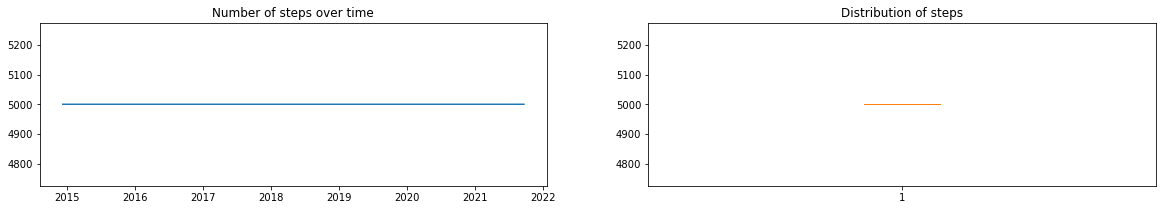

<Figure size 640x480 with 0 Axes>

In [10]:
daily_steps(test_df)

As expected the plots are flat because the dataset is constant

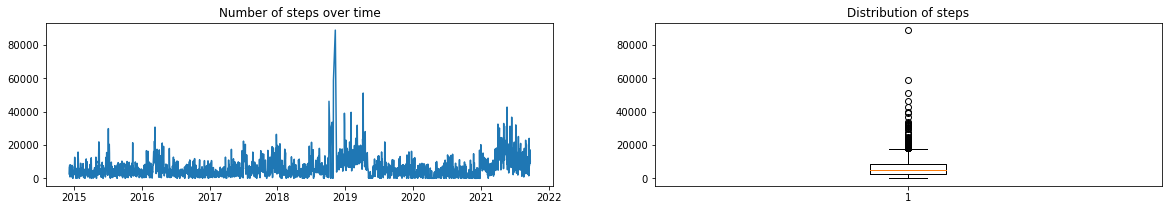

<Figure size 640x480 with 0 Axes>

In [11]:
daily_steps(df1)

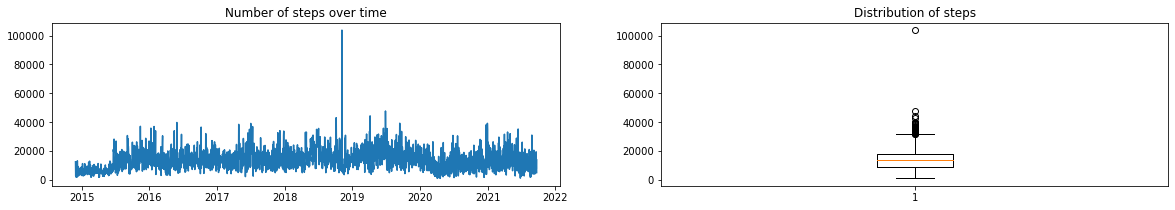

<Figure size 640x480 with 0 Axes>

In [12]:
daily_steps(df2)

Interestingly, there are a few days from both datasets where the respondent walked an incredible amount of steps, in some cases up to 90 thousand, we will remove days with more than 40000 steps and treat them as outliers

In [13]:
def clean_raw_df(df):
    # Convert date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Aggregate data into days
    df = df.groupby('Date').sum().reset_index()
    # Remove days with more than 40000 steps
    df[df['Count'] < 40000]
    return df

cleaned_1 = clean_raw_df(df1_raw)
cleaned_2 = clean_raw_df(df2_raw)

Different increments: YTD, weeks, months, whole years
Different metrics: average steps per day, total steps in 12 months
if its average steps per day, we could filter out days, and we'd look at different filter metrics

We now explore different ways of considering the driving question of `Last 12 months`, different ways of considering compliance, and different ways of comparing `last 12 months`.

First we create worker functions, here we create functions that decrement the dates in order to get the way it changes, as well as a few another functions to allow for different iterators and comparators to be  used.

In [14]:
# Main working function
def get_12_mo_comparison(metric, iterator):
    results = []
    for x,y in iterator:
        results.append(metric(x,y))
    return np.array(results)

# Considers days
def decrement_day(dt):
    return dt - timedelta(days = 1)

# Considers months
def decrement_month(dt):
    if dt.month > 1:
        return datetime(year = dt.year, month = dt.month - 1, day = dt.day)
    return datetime(year = dt.year - 1, month = 12, day = dt.day)

# Wraps function so its applied for all args provided
def get_single_return_wrapper(fn):
    def wrapper(*args):
        return [fn(dt) for dt in args]
    return wrapper

# Iterate subsets of time given df, operation to apply after subset, column to extract, and datetime incrementor
def ytd_iter(df, op, col, new_dt):
    start_1 = df['Date'].max()
    end_1 = datetime(year = start_1.year - 1, month = start_1.month, day = start_1.day)
    end_2 = datetime(year = start_1.year - 2, month = start_1.month, day = start_1.day)
    while end_2 >= df['Date'].min():
        y1 = df[(df['Date'] <= start_1) & (df['Date'] > end_1)][col] # Previous 12 months
        y2 = df[(df['Date'] <= end_1) & (df['Date'] > end_2)][col] # The 12 months before that
        yield op(y1), op(y2)
        start_1, end_1, end_2 = new_dt(start_1, end_1, end_2)

# Percentage where we walked more in the last 12 months to the 12 months before
def perc_greater(arr):
    return np.mean(arr>0)
def percent_metric(x,y, goal = 10000):
    return np.sum(x >= goal) - np.sum(y >= goal)

Here we define a function that takes in a dataframe and a integer goal that creates plots and outputs the percentage of times where the number of days which the goal was met compared to the 12 months before that. A percentage greater than 50% suggests that the person had, more often that not, walked more in the last 12 months compared to the 12 months before that.

In [15]:
%matplotlib inline

ignore = lambda x:x

def make_plot(df, goal):
    # Use the get 12 month comparison function from before to get the difference of last 12 months and 12 months before, 
    # decrementing 12 months each time and recomputing
    res_1_days_sum = get_12_mo_comparison(lambda x,y :percent_metric(x,y,goal), 
                                          ytd_iter(df, ignore, 'Count', 
                                                   get_single_return_wrapper(decrement_month)
                                                  )
                                         )
    print(perc_greater(res_1_days_sum)) # Get percentage of days where driving question was met

    # Get dates for plotting
    start_1 = df['Date'].max()
    dates = []
    end_1 = datetime(year = start_1.year - 1, month = start_1.month, day = start_1.day)
    end_2 = datetime(year = start_1.year - 2, month = start_1.month, day = start_1.day)
    dec = get_single_return_wrapper(decrement_month)
    while end_2 >= df['Date'].min():
        start_1, end_1, end_2 = dec(start_1, end_1, end_2)
        dates.append(start_1)

    # Plot results with dates
    plt.plot(dates,res_1_days_sum ,marker='x')
    plt.title(f'Did I reach {goal} steps in the last 12 months\n than the 12 months before that?')
    plt.xlabel('When am I asking the question?')
    plt.ylabel("How many more days did I reach my target last\n 12 months compared to the 12 before that?")
    plt.axhline(y=0, color='r', linestyle='-')

First we test the functions with the dummy dataset

0.0


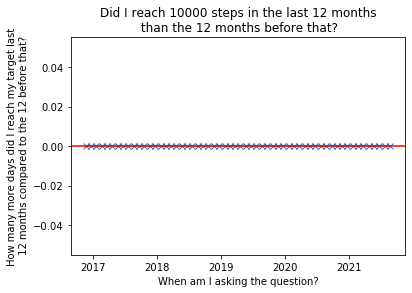

In [16]:
make_plot(test_df, 10000)

The plot is flat as expected from a constant dataset

Now we plot person 1 with a goal of 10000 steps

0.603448275862069


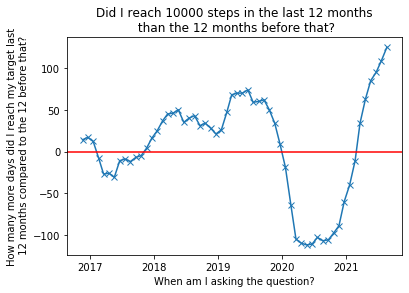

In [17]:
make_plot(cleaned_1,10000)

Here we can see that this person was progressively more and more active from 2018-2020, but experienced a sharp decline in reaching goals from 2020 onwards.

Now we take a look at person 2.

0.5517241379310345


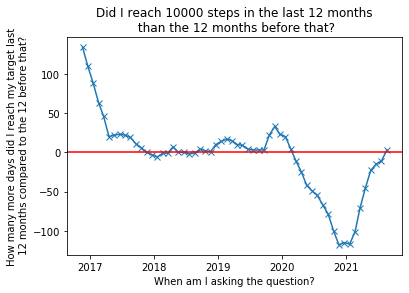

In [18]:
%matplotlib inline
make_plot(cleaned_2, 10000)

We can see that person 2 was much more consistent from 2018 to 2020 as the difference in the number of days of goal met was around 0 from 2018 to 2020, but similar to person 1 experienced a sharp decline from 2020 onwards. This is likely due to the Covid-19 pandemic.

Now we shift the goal posts back to 5000 steps.

0.5862068965517241


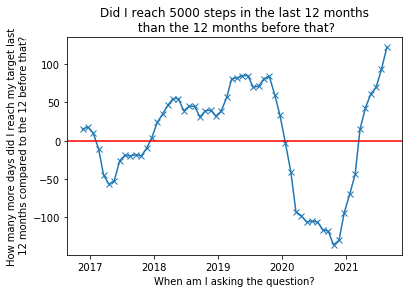

In [19]:
%matplotlib inline
make_plot(cleaned_1,5000)

This plot is similar to the plot with 10000 steps, with largely similar shapes

0.5344827586206896


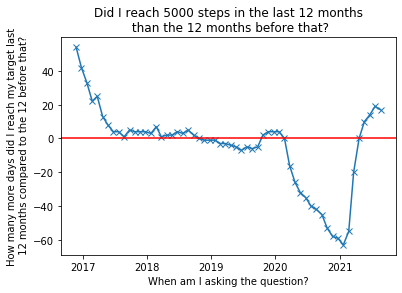

In [20]:
%matplotlib inline
make_plot(cleaned_2,5000)

Similarly with person 1, the reduced goal for person 2 also results in a plot with a largely identical shape.

We now investigate the effects of changing the goal on how each person is able to reach their goal in the last 12 months compare to the 12 months before that

3D plot using matplotlib

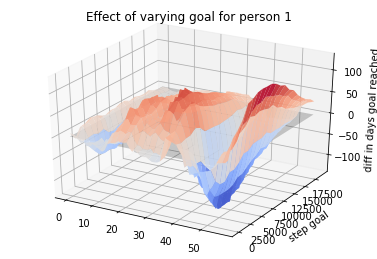

In [21]:
%matplotlib inline
X, Y, Z = [], [], []
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Compute values as before for 2D line plots but with varying goals to create a 3D plot
for lim in range(0,20000,1000):
    curr_met = lambda x,y : percent_metric(x,y,lim)
    cmpr = get_12_mo_comparison(curr_met, ytd_iter(cleaned_1, ignore, 'Count', get_single_return_wrapper(decrement_month)))
    Z.append(cmpr)
    X.append(list(range(len(cmpr))))
    Y.append([lim]*len(cmpr))
X,Y,Z = np.asarray(X),np.asarray(Y),np.asarray(Z)
X = X.max() - X

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0,alpha = 0.9)
ax.plot_surface(X, Y, 0*Z, alpha = 0.2, color='k')

ax.set_ylabel('step goal')
ax.set_zlabel('diff in days goal reached')
ax.set_title('Effect of varying goal for person 1')
fig = plt.gcf()
fig.set_size_inches(6.5, 4.5)
fig.savefig('test1png.png', dpi=100)

We can see that 3D the `z=0` plane does not show up well in `matplotlib`. This is a known issue, an alternative, `Mayavi` can be used

In [22]:
mlab.figure()
s1 = mlab.surf(Y, X, np.zeros_like(Z), warp_scale='auto', opacity = 0.3)
# Divide by max because of issues of Mayavi with different scales
# Although the value for z axis is not correct, shape is the same
s = mlab.surf(Y, X, (Z/Z.std()), warp_scale='auto')
mlab.axes(xlabel='Step goal', ylabel='n-th 2 year period', zlabel='days better 12mo')
s

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

We can see that for person 1, the lower the goal is, the larger the difference, meaning that the user was more likely to reach their goals for more days in the last 12 months compared to the year before that when the goal is lower, conversely as the goal increases, the difference between the last year and the year before that decreases.

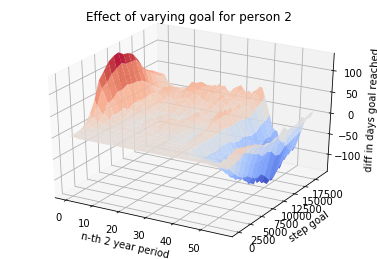

In [23]:
%matplotlib inline
X, Y, Z = [], [], []
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Compute values as before for 2D line plots but with varying goals to create a 3D plot
for lim in range(0,20000,1000):
    curr_met = lambda x,y : percent_metric(x,y,lim)
    cmpr = get_12_mo_comparison(curr_met, ytd_iter(cleaned_2, ignore, 'Count', get_single_return_wrapper(decrement_month)))
    Z.append(cmpr)
    X.append(list(range(len(cmpr))))
    Y.append([lim]*len(cmpr))
X,Y,Z = np.asarray(X),np.asarray(Y),np.asarray(Z)
X = X.max() - X

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0,alpha = 0.9)
ax.set_xlabel('n-th 2 year period')
ax.set_ylabel('step goal')
ax.set_zlabel('diff in days goal reached')
ax.set_title('Effect of varying goal for person 2')
fig = plt.gcf()
fig.set_size_inches(6.5, 4.5)
fig.savefig('test2png.png', dpi=100)

In [24]:
mlab.figure()
s1 = mlab.surf(Y, X, np.zeros_like(Z), warp_scale='auto', opacity = 0.3)
# Divide by max because of issues of Mayavi with different scales
# Although the value for z axis is not correct, shape is the same
s = mlab.surf(Y, X, (Z/Z.std()), warp_scale='auto')
mlab.axes(xlabel='Step goal', ylabel='n-th 2 year period', zlabel='days better 12mo')
s

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

However for person 2, the lower the goal, the more likely they were to reach their goal, and the smaller the difference between years. When the goal is increased, the difference between the years were much bigger, seen in the large area beneath the z=0 plane in the plot on the left and the higher peaks.

We also elected to use both `Mayavi` and `matplotlib` plots because both has strengths and weaknesses. `matplotlib` conveys uncertainty well with grids as opposed to a smooth surface, but `Mayavi` is able to display the $z=0$ plane which allows for better understanding of when the person walked more or less than the year before

Final outputs in case widgets don't load

Plot for person 1:
![title](savedplots/snapshot.png)
Plot for person 2:
![title](savedplots/snapshot_person_2.png)

In conclusion, whether or not a person achieves their goal of walking more in the last 12 months compared to the 12 months before that is dependent on their goal, and thus has no strict answer.

Libraries used

In [25]:
installed_packages = !pip freeze
used_packages = ['pandas', 'os', 'matplotlib','datetime','numpy','mayavi']
_ = [print(x) for x in installed_packages if any(x.startswith(u) for u in used_packages)]

matplotlib==3.1.3
mayavi==4.7.3
numpy==1.18.4+mkl
pandas==1.0.3
